In [1]:
import matplotlib.pyplot as plt
import open3d as o3d
import os
import sys
import h5py
from sklearn.decomposition import PCA 
import json
from sklearn.model_selection import train_test_split
import numpy as np
sys.path.append("../..")
sys.path.append("..")   
from data.utils import distinct_colors
from models.datasets import SorghumDatasetWithNormals, TreePartNetDataset, TreePartNetOriginalDataset, SorghumDatasetTPNFormat
from models.nn_models import *
from data.load_raw_data import load_real_ply_with_labels, load_pcd_plyfile_new_approach
from data.utils import distinct_colors
from train_and_inference.test import *
from models.utils import LeafMetrics

plt.style.use('seaborn')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_full_size_synthetic(ind, path, is_instance = False):
    file_names = os.listdir(path)

    _, test_names = train_test_split(
        file_names,
        test_size=0.2,
        random_state=42,
    )
    
    pcd = load_pcd_plyfile_new_approach(os.path.join(path,f"{test_names[ind]}"), is_instance)
    test_data = np.expand_dims(pcd['points_full'],0)
    test_labels = np.expand_dims(pcd['labels_full'],0)
    return test_data, test_labels

In [3]:
p_metric_calc = LeafMetrics("cpu")
c_metric_calc = ClusterBasedMetrics([0.25,0.5,0.75])

In [4]:
def draw_results(plt_points, plt_labels, plt_preds):
    fig = plt.figure(figsize=(10,10))
    
    all_labels = list(set(plt_labels))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))

    gt_colors = np.zeros((plt_labels.shape[0],3))
    for i, l in enumerate(all_labels):
        gt_colors[plt_labels == l, :] = d_colors[i]

    all_labels = list(set(plt_preds))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))
        
    pred_colors = np.zeros((plt_preds.shape[0],3))
    for i, l in enumerate(list(set(plt_preds))):
        pred_colors[plt_preds == l, :] = d_colors[i]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=gt_colors, alpha=1)
    ax1.grid(False)
    ax1.axis("off")
    ax1.set_facecolor("white")
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=pred_colors, alpha=1)
    ax2.grid(False)
    ax2.axis("off")
    ax2.set_facecolor("white")

    plt.tight_layout()
    plt.show()

def draw_and_save_pcd_plot(plt_labels, pca_raw_preds, prefix):
    if pca_raw_preds is not None:
        pca_2d = PCA(n_components = 2)
        pca_2d.fit(pca_raw_preds)
        data_pca_2d = pca_2d.transform(pca_raw_preds)
        
        d_colors = distinct_colors(len(list(set(plt_labels))))
        colors = np.zeros((plt_labels.shape[0],3))
        for i, l in enumerate(list(set(plt_labels))):
            colors[plt_labels == l, :3] = d_colors[i]
            
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.scatter(data_pca_2d[:,0],data_pca_2d[:,1], s=5, c=colors*1.4)
        fig.savefig(f"{prefix}_pca_plt.png")


In [5]:
model_name = "SorghumPartNetInstance"
trained_dataset = "SPNS"
exp_no = "08"
experiment_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/experiments/{model_name}/{trained_dataset}/EXP_{exp_no}_{model_name}_{trained_dataset}.json"
hyper_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/results/hparam_tuning_logs/{model_name}/{trained_dataset}/EXP_{exp_no}/DBSCAN_best_param.json"

experiment_params = load_json(experiment_param_path)

dataset_name = experiment_params["dataset"]
dataset_path = experiment_params["test_data"]
model_name = experiment_params["model_name"]
experiment_id = experiment_params["experiment_id"]
if dataset_name == "SPNS":
    point_key, label_key = "points", "labels"
elif dataset_name == "TPN":
    point_key, label_key = "points", "primitive_id"
model_path = os.path.join(
        "/speedy/ariyanzarei/sorghum_segmentation/results",
        "training_logs",
        model_name,
        dataset_name,
        experiment_id,
        "checkpoints",
    )
model = load_model(model_name, model_path)
hparams = load_json(hyper_param_path)
print(hparams)

{'eps': 2.008001479451607, 'minpoints': 19.0}


(0.8128319978713989, 0.4908786416053772, 0.7244204878807068, 0.5852099061012268)
{'mean_coverage': 0.6926326067382957, 'average_precision': 0.6333333333333333, 'average_recall': 0.7916666666666666}


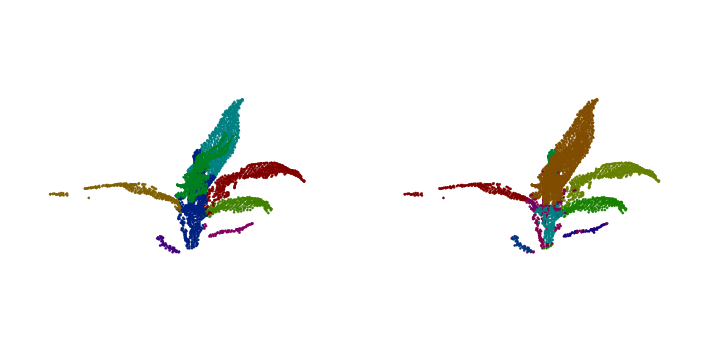

True

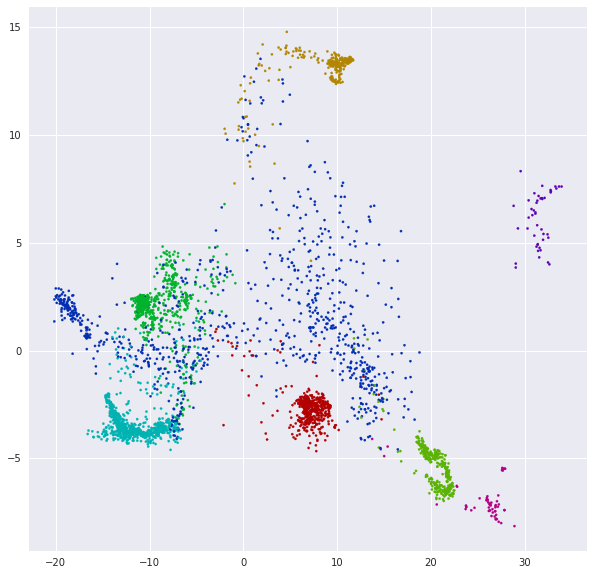

In [17]:
# hparams = {"eps": 2.20, "minpoints": 17}
ind = 0
points, label = load_data_directory("/space/ariyanzarei/sorghum_segmentation/dataset/SPNR", model_name)

t_points = torch.from_numpy(points[ind]).type(torch.DoubleTensor)

raw_preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetSemantic":
    preds = F.softmax(raw_preds, dim=1)
    preds = preds.squeeze().cpu().detach().numpy().T
    preds = np.argmax(preds, 1)
    raw_preds = None
elif model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(raw_preds, hparams['eps'], hparams['minpoints'])
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(raw_preds, hparams['eps'], hparams['minpoints'])

print(p_metric_calc(torch.from_numpy(preds).view(1,-1,1), torch.from_numpy(label[ind]).view(1,-1,1)))
print(c_metric_calc(torch.from_numpy(preds), torch.from_numpy(label[ind])))

draw_results(points[ind], label[ind], preds)
draw_and_save_pcd_plot(label[ind].squeeze(),raw_preds.squeeze().detach().numpy())

gt_ply = create_ply_pcd_from_points_with_labels(points[ind],label[ind])
pred_ply = create_ply_pcd_from_points_with_labels(points[ind],preds)

R = o3d.geometry.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))
gt_ply.rotate(R, center=(0, 0, 0))
pred_ply.rotate(R, center=(0, 0, 0))

o3d.io.write_point_cloud(f"syn_{ind}_gt.ply", gt_ply)
o3d.io.write_point_cloud(f"syn_{ind}_pred.ply", pred_ply)

(0.9509716033935547, 0.689123272895813, 0.9447933435440063, 0.7969550490379333)
{'mean_coverage': 0.7067969799036073, 'average_precision': 0.9, 'average_recall': 0.75}


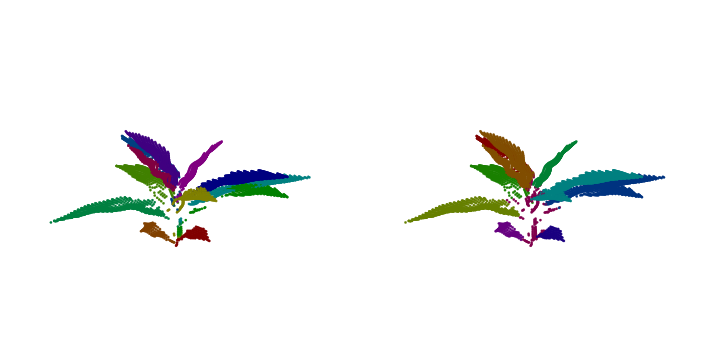

True

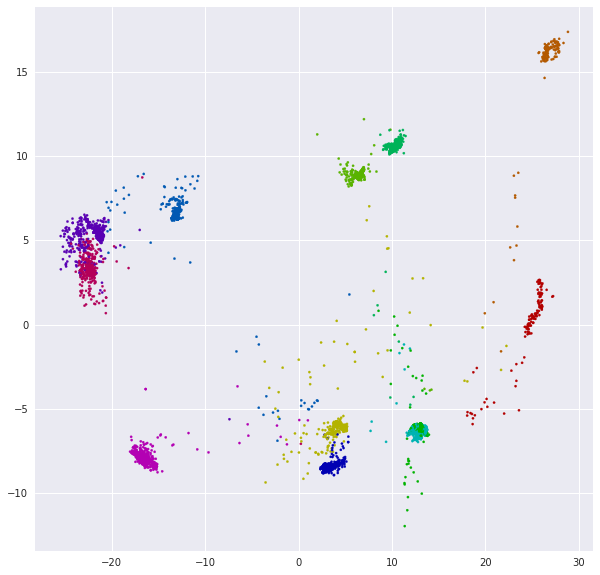

In [12]:
# hparams = {"eps": 2.5, "minpoints": 15}

ind = 641
test_data, test_labels = load_data_h5(dataset_path,point_key, label_key)

test_data, test_labels = load_full_size_synthetic(ind,"/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/", model_name != "SorghumPartNetSemantic")
ind = 0

t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)

raw_preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetSemantic":
    preds = F.softmax(raw_preds, dim=1)
    preds = preds.squeeze().cpu().detach().numpy().T
    preds = np.argmax(preds, 1)
    raw_preds = None
elif model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(raw_preds, hparams['eps'], hparams['minpoints'])
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(raw_preds)

print(p_metric_calc(torch.from_numpy(preds).view(1,-1,1), torch.from_numpy(test_labels[ind]).view(1,-1,1)))
print(c_metric_calc(torch.from_numpy(preds), torch.from_numpy(test_labels[ind].squeeze())))

draw_results(test_data[ind], test_labels[ind].squeeze(), preds)
draw_and_save_pcd_plot(test_labels[ind].squeeze(),raw_preds.squeeze().detach().numpy())

save_points = (test_data[ind] - np.min(test_data[ind], 0))
gt_ply = create_ply_pcd_from_points_with_labels(save_points,test_labels[ind].squeeze())
pred_ply = create_ply_pcd_from_points_with_labels(save_points,preds)

R = o3d.geometry.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))
gt_ply.rotate(R, center=(0, 0, 0))
pred_ply.rotate(R, center=(0, 0, 0))

o3d.io.write_point_cloud("gt.ply", gt_ply)
o3d.io.write_point_cloud("pred.ply", pred_ply)